In [3]:
import tensorflow as tf
import numpy as np
import os
import time
import uuid
import cv2
from matplotlib import pyplot as plt
import json
import xml.etree.ElementTree as ET

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/fire-dataset/train/images/img (100).jpg')

In [ ]:
tree = ET.parse('/content/drive/MyDrive/Colab Notebooks/fire-dataset/train/annotations/img (100).xml')

In [ ]:
root = tree.getroot()

In [ ]:
coords = [0,0,0,0]
coords[0] = int(root[6][4][0].text)
coords[1] = int(root[6][4][1].text)
coords[2] = int(root[6][4][2].text)
coords[3] = int(root[6][4][3].text)

In [ ]:
coords

[106, 120, 198, 166]

In [ ]:
coords = list(np.divide(coords, [img.shape[1],img.shape[0],img.shape[1],img.shape[0]]))

In [ ]:
coords

[0.3897058823529412,
 0.6486486486486487,
 0.7279411764705882,
 0.8972972972972973]

In [ ]:
import albumentations as alb
augmentor = alb.Compose([alb.RandomCrop(width=150, height=150), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['fire'])

In [ ]:
augmented

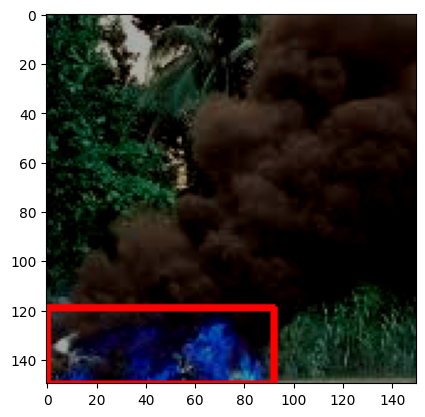

In [ ]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [150,150]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [150,150]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [ ]:
for partition in ['train','validation']: 
    for image in os.listdir(os.path.join('/content/drive/MyDrive/Colab Notebooks/fire-dataset', partition, 'images')):
        img = cv2.imread(os.path.join('/content/drive/MyDrive/Colab Notebooks/fire-dataset', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        
        label_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/fire-dataset', partition, 'annotations', f'{image.split(".")[0]}.xml')
        if os.path.exists(label_path):
            tree = ET.parse(label_path)
            root = tree.getroot()

            coords[0] = int(root[6][4][0].text)
            coords[1] = int(root[6][4][1].text)
            coords[2] = int(root[6][4][2].text)
            coords[3] = int(root[6][4][3].text)
            coords = list(np.divide(coords, [img.shape[1],img.shape[0],img.shape[1],img.shape[0]]))

        try:
          for x in range(10):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('/content/drive/MyDrive/Colab Notebooks/aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('/content/drive/MyDrive/Colab Notebooks/aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Requested crop size (150, 150) is larger than the image size (137, 367)
Requested crop size (150, 150) is larger than the image size (135, 240)
Requested crop size (150, 150) is larger than the image size (135, 240)
Requested crop size (150, 150) is larger than the image size (135, 240)
Requested crop size (150, 150) is larger than the image size (147, 342)
Requested crop size (150, 150) is larger than the image size (135, 240)


In [4]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [5]:
train_images = tf.data.Dataset.list_files('/content/drive/MyDrive/Colab Notebooks/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [6]:
val_images = tf.data.Dataset.list_files('/content/drive/MyDrive/Colab Notebooks/aug_data/validation/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [7]:
train_images.as_numpy_iterator().next()

array([[[0.12720588, 0.08737745, 0.14185049],
        [0.07463235, 0.04479166, 0.08884804],
        [0.10925245, 0.09197304, 0.13051471],
        ...,
        [0.42610294, 0.4922794 , 0.36139706],
        [0.44632354, 0.51280636, 0.3767157 ],
        [0.4708946 , 0.5375613 , 0.3983456 ]],

       [[0.12867647, 0.11329657, 0.18094362],
        [0.128125  , 0.11819853, 0.17346814],
        [0.11709559, 0.11911765, 0.1627451 ],
        ...,
        [0.3759804 , 0.4372549 , 0.33529413],
        [0.4148897 , 0.4776961 , 0.36930147],
        [0.44938725, 0.5131127 , 0.40085784]],

       [[0.10753676, 0.12555148, 0.20116422],
        [0.159375  , 0.17457108, 0.24025735],
        [0.11464461, 0.1341299 , 0.18664216],
        ...,
        [0.38455883, 0.4393995 , 0.38125   ],
        [0.40508577, 0.46145833, 0.396875  ],
        [0.41936275, 0.4757353 , 0.41004902]],

       ...,

       [[0.06752451, 0.12671569, 0.01593137],
        [0.10232843, 0.16758579, 0.04963235],
        [0.11795343, 0

In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [9]:
train_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/Colab Notebooks/aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [10]:
val_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/Colab Notebooks/aug_data/validation/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.013336, 0.      , 0.6265  , 0.28    ], dtype=float16))

In [12]:
len(train_images), len(train_labels), len(val_images), len(val_labels)

(4070, 4070, 890, 890)

In [13]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [14]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [15]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4067, 0.8135, 0.4866, 0.9067],
        [0.2866, 0.3066, 0.9   , 0.9   ],
        [0.    , 0.36  , 0.3267, 0.78  ],
        [0.24  , 0.2   , 0.7666, 0.7334],
        [0.1934, 0.2734, 0.547 , 0.4866],
        [0.    , 0.1934, 0.44  , 0.553 ],
        [0.3132, 0.3   , 0.8867, 0.6465],
        [0.    , 0.32  , 0.36  , 0.7134]], dtype=float16))

In [16]:
data_samples = train.as_numpy_iterator()

In [17]:
res = data_samples.next()

In [18]:
res[1][1][1]

array([0.    , 0.    , 0.56  , 0.4666], dtype=float16)

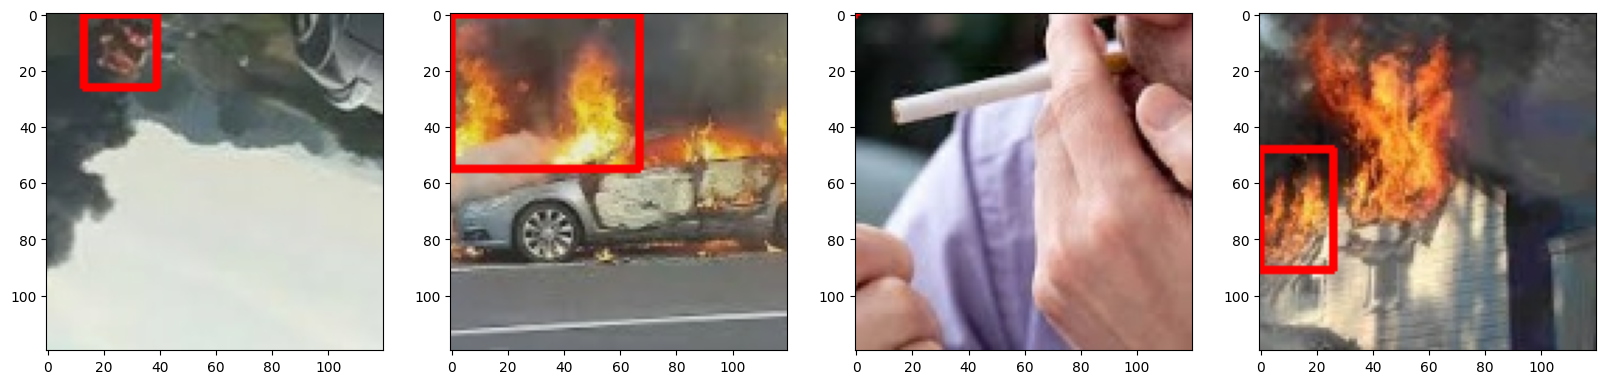

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [21]:
vgg = VGG16(include_top=False)

In [22]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [23]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    firetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return firetracker

In [24]:
firetracker = build_model()

In [25]:
firetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [26]:
X, y = train.as_numpy_iterator().next()

In [27]:
X.shape

(8, 120, 120, 3)

In [30]:
classes, coords = firetracker.predict(X)

1/1 [==============================] - 0s 29ms/step


In [31]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [32]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [33]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [34]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [35]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.1349974>

In [36]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.510707>

In [37]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.1349974>

In [38]:
class FireTracker(Model): 
    def __init__(self, firetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = firetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [39]:
model = FireTracker(firetracker)

In [40]:
model.compile(opt, classloss, regressloss)

In [41]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=100, validation_data=val, callbacks=[tensorboard_callback])

509/509 [==============================] - 48s 71ms/step - total_loss: 4.5933e-04 - class_loss: 1.5982e-08 - regress_loss: 4.5932e-04 - val_total_loss: 0.1460 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.1460
Epoch 100/100
509/509 [==============================] - 47s 70ms/step - total_loss: 4.5731e-04 - class_loss: 2.7436e-08 - regress_loss: 4.5730e-04 - val_total_loss: 0.0960 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0960


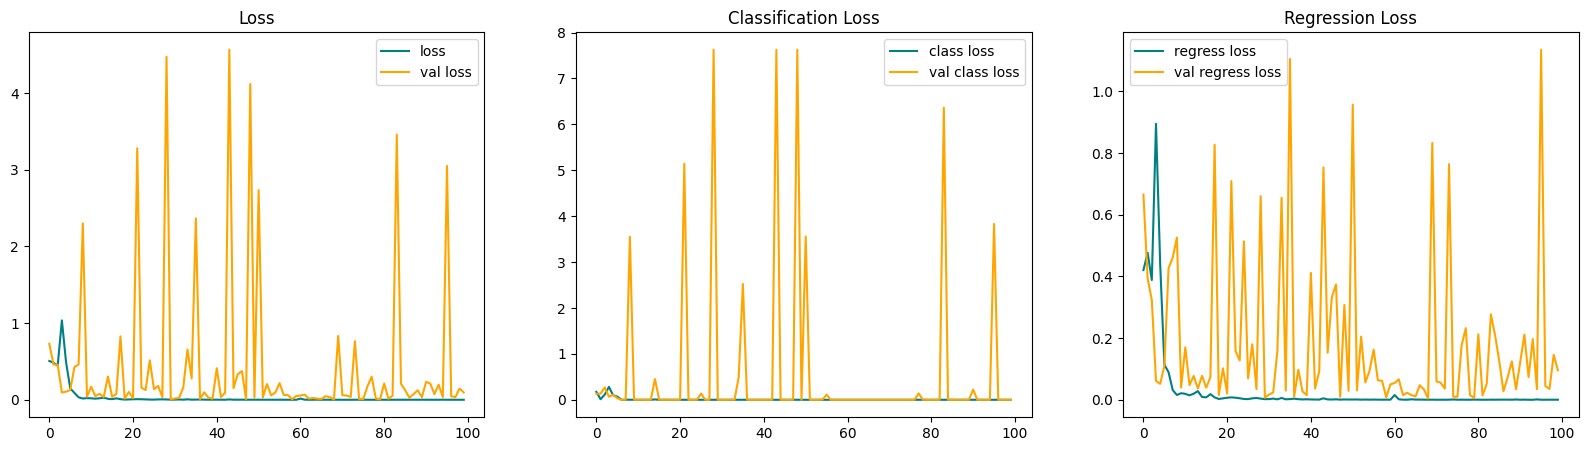

In [42]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [49]:
from tensorflow.keras.models import load_model
firetracker.save('/content/drive/MyDrive/Colab Notebooks/firetracker_final.h5')

In [44]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = firetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [45]:
test_data = val.as_numpy_iterator()

In [46]:
test_sample = test_data.next()

In [47]:
yhat = firetracker.predict(test_sample[0])

1/1 [==============================] - 0s 22ms/step


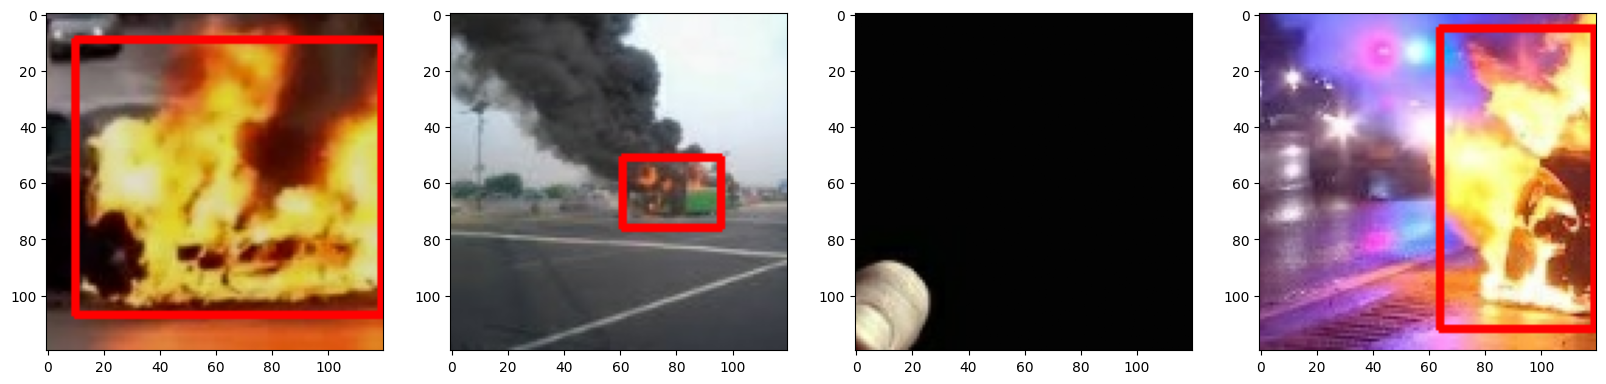

In [48]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)